# A world made of words

At the end of the last session, we had imported some text into R in a tabular format, with each row corresponding to a unit of interest in our document. In this session we break the text into words and explore how word frequency is related to the balance between style and content, as well as some basic methods for classifying texts.

Now that we've had some experience processing documents from Project Gutenberg by hand, we can turn to a shortcut: the package `gutenbergr` automates the process of downloading documents by gutenberg ID and turning them into tibbles.

In [1]:
# only needed once
install.packages('gutenbergr')


The downloaded binary packages are in
	/var/folders/_k/nhmmjzg96r318bm9jvyvv7ph0000gn/T//Rtmp6Fa5DF/downloaded_packages


In [2]:
library(tidyverse)
library(tidytext)
library(gutenbergr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Let’s recap our work from last time, using gutenbergr. I'll use pipes to chain many of the steps together, but for readability it often helps to chunk your work into a couple of stages.

The Project Gutenberg ID for *Idylls of the King* is `610`.

In [3]:
king_lines <- gutenberg_download(610)

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest

Using mirror http://aleph.gutenberg.org



In [4]:
king_lines <- king_lines %>%
    mutate(
        is_break = str_starts(text, '      \\w'),
        section = cumsum(is_break)
    ) %>%
    filter(!is_break & text != '') %>%
    filter(section > 4) %>%
    mutate(section = section - 4)

In [5]:
king_lines <- king_lines %>%
    group_by(section) %>%
    mutate(line = row_number()) %>%
    ungroup() %>%
    select(section, line, text)

How does it look?

In [6]:
king_lines

section,line,text
<dbl>,<int>,<chr>
1,1,"These to His Memory—since he held them dear,"
1,2,Perchance as finding there unconsciously
1,3,"Some image of himself—I dedicate,"
1,4,"I dedicate, I consecrate with tears—"
1,5,These Idylls.
1,6,And indeed He seems to me
1,7,"Scarce other than my king’s ideal knight,"
1,8,“Who reverenced his conscience as his king;
1,9,"Whose glory was, redressing human wrong;"


## Breaking into words

The package **tidytext** contains tokenizers built for tibbles. Depending on your text, language, and application, you may prefer a more full-featured NLP package for tokenization. But for now we’ll try this approach.

In tidyr, **unnest** refers to spreading the contents of a list out into multiple rows. The `unnest_tokens()` function provided by tidytext first splits a string into **tokens**, i.e. component features of interest, and then unnests the result.

We’re going to start with word tokenization, but one nice thing about tidytext is its ability to do **ngrams**, something we'll check out a bit later.

We pass `unnest_tokens()` a couple of arguments:
- `output`: the new column we want to create
- `input`: the column containing the text to tokenize
- optionally, a string describing the kind of tokens we want, default: "words"

See `help(unnest_tokens)` for details.

In [7]:
king_words <- king_lines %>%
    unnest_tokens(output=word, input=text)

In [8]:
str(king_words)

tibble [85,125 × 3] (S3: tbl_df/tbl/data.frame)
 $ section: num [1:85125] 1 1 1 1 1 1 1 1 1 1 ...
 $ line   : int [1:85125] 1 1 1 1 1 1 1 1 1 2 ...
 $ word   : chr [1:85125] "these" "to" "his" "memory" ...


In [9]:
head(king_words, n=20)

section,line,word
<dbl>,<int>,<chr>
1,1,these
1,1,to
1,1,his
1,1,memory
1,1,since
1,1,he
1,1,held
1,1,them
1,1,dear


### Basic tallying

Now that we have the text broken down into words, counting them is straightforward. Here are all the word counts, with the most common at the top:

In [10]:
wc <- king_words %>%
    group_by(word) %>%
    summarize(count=n()) %>%
    arrange(desc(count))

In [11]:
str(wc)

tibble [6,960 × 2] (S3: tbl_df/tbl/data.frame)
 $ word : chr [1:6960] "and" "the" "of" "a" ...
 $ count: int [1:6960] 4621 4494 1903 1557 1556 1277 1248 970 946 923 ...


In [12]:
head(wc)

word,count
<chr>,<int>
and,4621
the,4494
of,1903
a,1557
to,1556
in,1277


In [13]:
tail(wc)

word,count
<chr>,<int>
youthful,1
youthhood,1
youths,1
zigzag,1
zone,1
zones,1


### The Zipfian curve

We can see that the word frequencies drop off quickly. In the early 20th century, George Zipf described the apparent universality of this phenomenon, which has come to be called ["Zipf's Law"](https://en.wikipedia.org/wiki/Zipf%27s_law). In general, we expect the log of word frequency to decrease linearly with log of word rank.

Let's plot the fequencies with **ggplot2** to observe this. First, here are the raw counts—they drop off precipitously with rank:

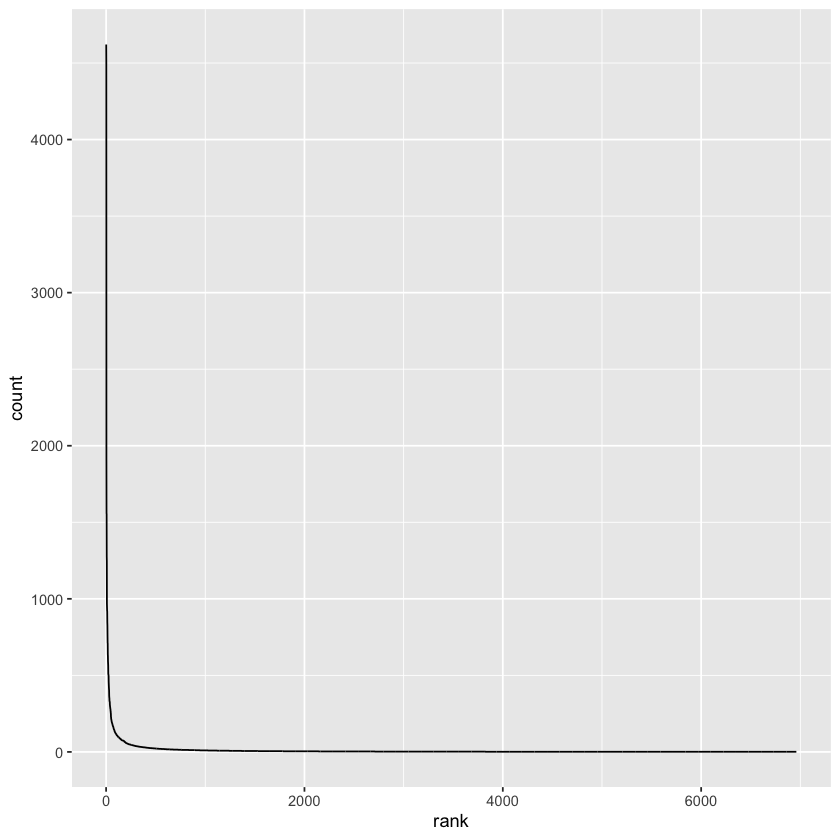

In [14]:
wc %>% 
    mutate(rank=row_number()) %>%
ggplot() +
    aes(x=rank, y=count) +
    geom_line()

Here they are again on a log-log plot:

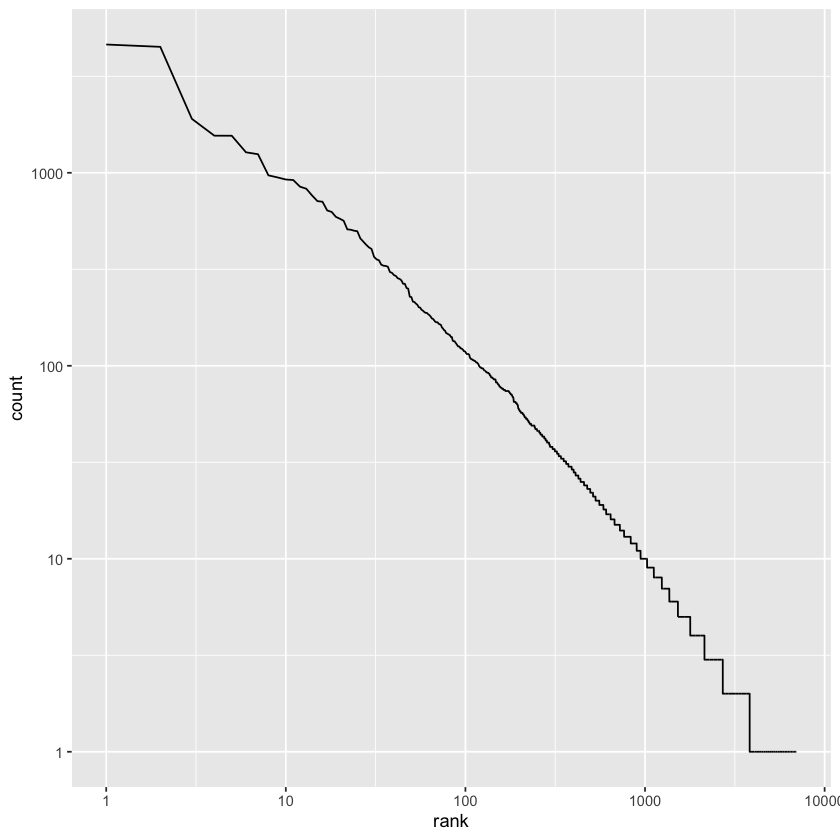

In [15]:
wc %>% 
    mutate(rank=row_number()) %>%
ggplot() +
    aes(x=rank, y=count) +
    geom_line() +
    scale_x_log10() +
    scale_y_log10()

### More on word frequency

So what are the top words in Tennyson's poems? They seem pretty bland...

In [16]:
head(wc)

word,count
<chr>,<int>
and,4621
the,4494
of,1903
a,1557
to,1556
in,1277


The **most frequent words** (MFWs) are almost exclusively **function words**, that is, words that are more related to how the language works than what the text is talking about (i.e. **content words**).

What you do with these words probably has a lot to do with what tasks you're interested in. The world of computational text analysis tends to be divided into those who prune MFWs before they even get started and those who, on the contrary, throw away everything else.

#### function words are useful for:
- authorship attribution
- stylometry
- some natural language processing

#### content words are useful for:
- information retrieval
- word vectors
- sentiment analysis

In general, analyses concerned with style have tended to favour MFWs (though sometimes with culling of the *top* most frequent words), while analyses concerned with content have tended to throw them away. Underlying this dichotomy is a more-or-less well-articulated assumption that *style and content are orthogonal*, or independent of each other.

So, for example, authorship attribution assumes that an author’s **stylistic fingerprint** is independent of what they’re writing about, and that an author might potentially write about any subject. If I really get to the essence of what makes J.K. Rowling’s language her own, then it should have nothing to do with wizards, but apply equally to detective novels, and perhaps even more diverse genres.

On the other hand, information retrieval assumes that all documents on a certain subject share certain properties regardless of who wrote them, and that a given subject might be written about in any style. A perfect model of the topic *baseball*, for example, would match biographies of players, sports news articles, fiction, and maybe even "Casey at the Bat."

### Theoretical and practical considerations

I am personally opposed to these assumptions on ideological grounds: both style and content are transmitted in a single channel, the stream of language, and there is nothing to stop leakage between them. In my own field, for example, there is much debate over whether the epithet in a phrase like "swift-footed Achilles" is style or content. And Roman authors frequently played with the idea that style and content were intimately connected: Ovid, for example, says explicitly (if with tongue in cheek) in *Amores* 1.1 that he’s incapable of writing about war in the elegiac metre.

For practical purposes, however, the division between style and content proves very useful. There isn't one firm threshold that separates function words from content, but rather each study involves some tuning to find the parameters that work best in context. Meanwhile, interest in the "middle" part of the frequency spectrum is increasing, and the dichotomy I described above was a bit overstated. You can, for example, see some cool visualizations of the effectiveness of various word-frequency windows for authorship using Stylo [here](https://doi.org/10.1093/llc/fqr031).

## From single texts to corpora

Let's consider how word counts scale as we add more texts. Let's compare selected children's novels by two authors from the turn of the last century, E. Nesbit and L.M. Montgomery.

In [17]:
corpus <- read_csv('https://raw.githubusercontent.com/cwf2/rostock_r/main/data/novels.csv')
corpus

Rows: 12 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): author, title
dbl (2): year, gutenberg_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


author,title,year,gutenberg_id
<chr>,<chr>,<dbl>,<dbl>
Montgomery,Anne of Green Gables,1908,45
Montgomery,Anne of Avonlea,1909,47
Montgomery,Anne of the Island,1915,51
Montgomery,Anne's House of Dreams,1917,544
Montgomery,Rilla of Ingleside,1921,3796
Montgomery,Rainbow Valley,1919,5343
Nesbit,The Enchanted Castle,1907,3536
Nesbit,The Railway Children,1906,1874
Nesbit,The Story of the Treasure Seekers,1899,770


We'll download all the novels at once using gutenbergr. In the interest of time we won't worry about a lot of cleanup.

In [18]:
corpus_lines <- gutenberg_download(corpus$gutenberg_id)

In [19]:
str(corpus_lines)

tibble [104,478 × 2] (S3: tbl_df/tbl/data.frame)
 $ gutenberg_id: int [1:104478] 45 45 45 45 45 45 45 45 45 45 ...
 $ text        : chr [1:104478] "ANNE OF GREEN GABLES" "" "By Lucy Maud Montgomery" "" ...


The corpus now has over 100,000 lines of text! Next, we'll tokenize into words:

In [20]:
corpus_words <- corpus_lines %>% 
    unnest_tokens(output=word, input=text)

In [21]:
str(corpus_words)

tibble [908,701 × 2] (S3: tbl_df/tbl/data.frame)
 $ gutenberg_id: int [1:908701] 45 45 45 45 45 45 45 45 45 45 ...
 $ word        : chr [1:908701] "anne" "of" "green" "gables" ...


That produced a table with nearly a million rows! Each row has a single `word`, as well as the `gutenberg_id` it belongs to.

Now we'll summarise. This code
- groups by `gutenberg_id` and `word`, i.e., takes together all occurrences of a given word in a text
- summarizes by the function `n()`, which is just a count of rows; in my summary, I’m also chosing to name this count `n`
- orders the results in decreasing order by `n` (one reason to name it earlier is so I can refer to it here)

In [22]:
counts_by_book <- corpus_words %>%
    group_by(gutenberg_id, word) %>%
    summarize(n=n()) %>% 
    arrange(desc(n))

`summarise()` has grouped output by 'gutenberg_id'. You can override using the
`.groups` argument.


In [23]:
head(counts_by_book)

gutenberg_id,word,n
<int>,<chr>,<int>
837,the,4581
3796,the,4245
836,the,4067
3536,the,4003
45,the,3925
3796,and,3591


In fact, this workflow is a common enough task that there’s a shortcut for it, `count()`. The following does exactly the same thing:

In [24]:
counts_by_book <- corpus_words %>%
    count(gutenberg_id, word, sort=TRUE)

In [25]:
head(counts_by_book)

gutenberg_id,word,n
<int>,<chr>,<int>
837,the,4581
3796,the,4245
836,the,4067
3536,the,4003
45,the,3925
3796,and,3591


Does the `counts_by_book` table make sense? It has one row for every unique `gutenberg_id`, `word` pairing, along with the count for that word in that book.

Maybe you’re imagining a table with one row per book and a column for every word count. We’ll definitely see that model in text analysis: it’s often called a [**document-term matrix**](https://en.wikipedia.org/wiki/Document-term_matrix). One issue with that representation is that not every word exists in every document. Just the opposite, in fact: it produces what is called a "sparse matrix", in which most of the cells are zeros.

## From counts to frequencies

If we want to compare the novels of our corpus, we need to account for the fact that some novels are longer than others. The simplest way is to divide each count by the total number of words in the document. (Because the resulting numbers are so low, it’s common to see frequencies reported per 1000 words.)

To get the total words count per document, we can group the per-book counts and take the sum.

In [26]:
totals_by_book <- counts_by_book %>%
    group_by(gutenberg_id) %>%
    summarize(total=sum(n))

In [27]:
totals_by_book

gutenberg_id,total
<int>,<int>
45,103554
47,89058
51,77519
544,80903
770,53428
836,62614
837,69667
1874,60195
3536,68995


In the interest of keeping book-level data in the same place, I’m going to do a **join** between `totals_by_book`, which just has the per-book word-counts, and `corpus`, my original table of metadata on the novels.

A join merges two tables based on a common column. There are several kinds of join, depending on whether you want complete data from either or both tables, or only those rows that the two have in common. 

In this case, I’m going to use a **left join**, which means I want everything from the left-hand table (in this case, `corpus`) plus any rows from the right that match. R will figure out that I want to join on the column `gutenberg_id` because that’s the only one the two tables have in common. 

A **right join** would give me all the rows of the right-hand table plus any from the left that match on the common column, while a **full join** would give me all rows from both tables.

An **inner join** gives me only the those rows that match both tables. In fact, in this case it hardly matters which join I choose, because both tables have the same number of rows and the same values for `gutenberg_id`. I just want to be certain that the right total goes with the right row in `corpus`.

You can read more about joins [here](https://r4ds.had.co.nz/relational-data.html#understanding-joins).


In [28]:
corpus <- corpus %>% left_join(totals_by_book)

Joining, by = "gutenberg_id"


In [29]:
corpus

author,title,year,gutenberg_id,total
<chr>,<chr>,<dbl>,<dbl>,<int>
Montgomery,Anne of Green Gables,1908,45,103554
Montgomery,Anne of Avonlea,1909,47,89058
Montgomery,Anne of the Island,1915,51,77519
Montgomery,Anne's House of Dreams,1917,544,80903
Montgomery,Rilla of Ingleside,1921,3796,105847
Montgomery,Rainbow Valley,1919,5343,82147
Nesbit,The Enchanted Castle,1907,3536,68995
Nesbit,The Railway Children,1906,1874,60195
Nesbit,The Story of the Treasure Seekers,1899,770,53428


Watch what happens when we do a left join between `counts_by_book` and `totals_by_book`. `counts_by_book` has a lot more rows than `totals_by_book`, but they share a common column, `gutenberg_id`. R will use that column to look up the appropriate row in `totals_by_book` and give each row in `counts_by_book` the total for its respective id.

In [30]:
counts_by_book %>% left_join(totals_by_book)

Joining, by = "gutenberg_id"


gutenberg_id,word,n,total
<int>,<chr>,<int>,<int>
837,the,4581,69667
3796,the,4245,105847
836,the,4067,62614
3536,the,4003,68995
45,the,3925,103554
3796,and,3591,105847
47,the,3521,89058
45,and,3398,103554
1874,the,3366,60195


Now that we have the correct denominator available on each row of the counts table, we can divide to get a standard measure of word frequency in the book. I'm going to multiply by 1000 to make the number easier to read.

In [31]:
counts_by_book <- counts_by_book %>%
    left_join(totals_by_book) %>%
    mutate(freq = 1000 * n / total)

Joining, by = "gutenberg_id"


In [32]:
head(counts_by_book)

gutenberg_id,word,n,total,freq
<int>,<chr>,<int>,<int>,<dbl>
837,the,4581,69667,65.75567
3796,the,4245,105847,40.10506
836,the,4067,62614,64.95352
3536,the,4003,68995,58.01870
45,the,3925,103554,37.90293
3796,and,3591,105847,33.92633


## Function words

Let’s do some basic comparisons. What about two very frequent words, "and" and "the": these words are common to the vast majority of utterances in English. Their use is very hard to avoid, and they’re so frequent that they easily pass completely unnoticed by authors and readers alike, fading into the background of language.

And yet, studies of authorship dating back over a century have noted that the use of these words is often characteristic of specific authors. Over our lives we develop habits of composing our sentences that can become both stable and unconscious, making them ideal "fingerprints" for authorship.

Of course, no-one would make forensic claims today based on raw frequencies of only two words, but working through a toy example can show something of their power.

In [33]:
counts_by_book %>% filter(word %in% c('and', 'the'))

gutenberg_id,word,n,total,freq
<int>,<chr>,<int>,<int>,<dbl>
837,the,4581,69667,65.75567
3796,the,4245,105847,40.10506
836,the,4067,62614,64.95352
3536,the,4003,68995,58.01870
45,the,3925,103554,37.90293
3796,and,3591,105847,33.92633
47,the,3521,89058,39.53603
45,and,3398,103554,32.81380
1874,the,3366,60195,55.91827


Ok, now I do want a document-term layout, with "and" and "the" as my columns, and `freq` as the cell data. This can be done with `pivot_wider()`. We can drop the `n` and `total` columns.

In [34]:
simple_dtm <- counts_by_book %>% 
    select(gutenberg_id, word, freq) %>%
    filter(word %in% c('and', 'the')) %>%
    pivot_wider(names_from=word, values_from=freq)

In [35]:
simple_dtm

gutenberg_id,the,and
<int>,<dbl>,<dbl>
837,65.75567,38.66967
3796,40.10506,33.92633
836,64.95352,45.03785
3536,58.01870,36.58236
45,37.90293,32.81380
47,39.53603,32.88868
1874,55.91827,41.06653
544,40.88847,30.97537
17314,57.58206,40.60321


Actually, I want the names of the authors on this table too. That’ll be another join. I’m going to `select()` the columns I want from `corpus` and then `right_join()` with `simple_dtm`. That lets me use pipes to craft a single chain of verbs...

In [36]:
simple_dtm <- corpus %>%
    select(gutenberg_id, author) %>%
    right_join(simple_dtm)

Joining, by = "gutenberg_id"


In [37]:
simple_dtm

gutenberg_id,author,the,and
<dbl>,<chr>,<dbl>,<dbl>
45,Montgomery,37.90293,32.81380
47,Montgomery,39.53603,32.88868
51,Montgomery,36.76518,30.41835
544,Montgomery,40.88847,30.97537
3796,Montgomery,40.10506,33.92633
5343,Montgomery,37.62767,32.45402
3536,Nesbit,58.01870,36.58236
1874,Nesbit,55.91827,41.06653
770,Nesbit,45.29460,47.74650


Let’s plot the points and see whether these two authors’ use of "and" and "the" is enough to separate their works...

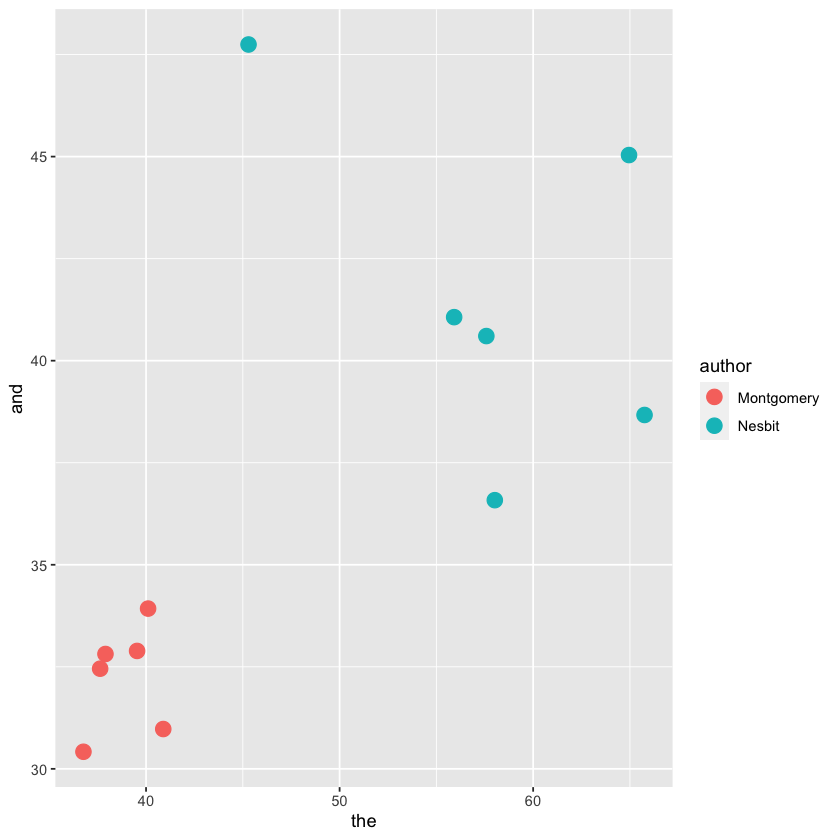

In [38]:
ggplot(simple_dtm) + 
    aes(x=the, y=and, col=author) +
    geom_point(size=4)

Wow... this is a pretty extreme example, but an illustrative one. Not only do these two word frequencies perfectly separate the authors, but in fact either one of them alone would be sufficient.

Now the real test of an authorship model is whether we can correctly identify unknown samples. Let’s introduce some additional novels without revealing their authors.

The code below looks a bit unwieldy, but it’s just a concise way of repeating all the steps we did above, now for the new texts.

In [39]:
# throw some unknown samples into the mix
unknowns_id <- c(5342, 61236, 50361, 27903)

unknowns_dtm <- gutenberg_download(unknowns_id) %>%          # download from pg
    unnest_tokens(word, text) %>%                            # tokenize
    count(gutenberg_id, word, sort=TRUE) %>%                 # get word counts
    group_by(gutenberg_id) %>%                               # group by doc (for per-doc totals in next line)
    mutate(total = sum(n), freq=1000*n/total) %>%            # create the 'total' row as sum of word counts
    select(gutenberg_id, word, freq) %>%                     # keep only the columns we need                     
    filter(word %in% c('the', 'and')) %>%                    # keep only rows we need
    pivot_wider(names_from=word, values_from=freq) %>%       # turn 'word' values into new cols
    mutate(author='unknown')                                 # add an author column

Here are our mystery samples:

In [40]:
unknowns_dtm

gutenberg_id,the,and,author
<int>,<dbl>,<dbl>,<chr>
61236,38.44895,32.08243,unknown
5342,46.14497,31.67943,unknown
27903,61.27156,43.10402,unknown
50361,65.38161,40.95618,unknown


Here, we join the new samples to the old ones and graph everything again. This time I’m adding the sample id numbers so we can see which of the unknown texts are which.

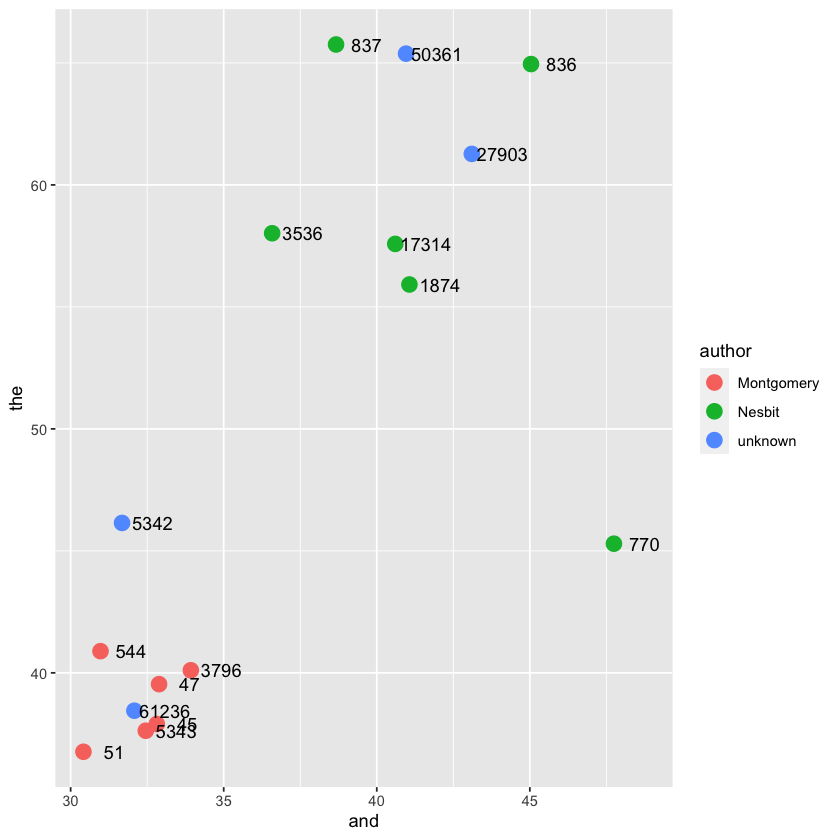

In [41]:
simple_dtm %>%
    bind_rows(unknowns_dtm) %>%

ggplot() +
    aes(x=and, y=the, col=author) +
    geom_point(size=4) +
    geom_text(aes(label=gutenberg_id), col='black', nudge_x=1)


### The reveal

Here are the identities of the mystery samples:

|gutenberg_id|author|title|
| --- | --- | --- |
| 5342  | Montgomery | The Story Girl |
| 27903 | Nesbit | The Magic World |
| 50361 | Nesbit | Wet Magic |
| 61236 | Montgomery | Emily of New Moon |

## A final look at most frequent words

By now I’m a little curious about Montgomery’s style... she uses both of these really frequent words quite a bit less than Nesbit. If she’s using the most common words less, is she using rarer words more? Does she simply have a bigger vocabulary so that all frequencies are slightly lower?

Let’s compare the Zipf curves for these two authors—I'm curious to see whether they have different slopes.

Joining, by = c("gutenberg_id", "total")
Adding missing grouping variables: `gutenberg_id`


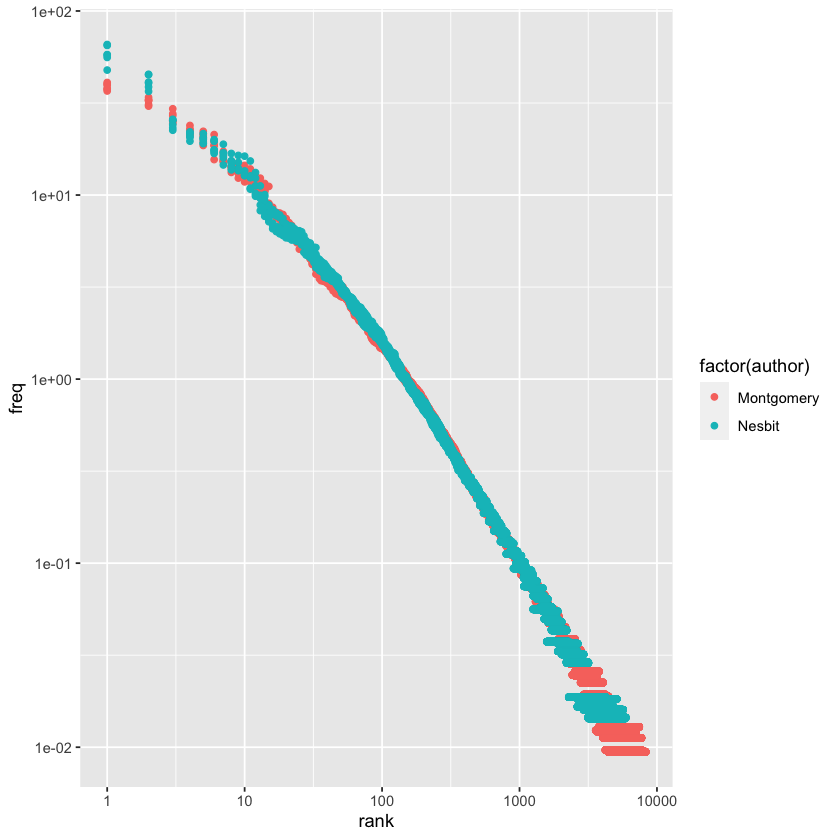

In [42]:
counts_by_book %>%
    left_join(corpus) %>%            # because I want author from the corpus table
    group_by(gutenberg_id) %>%       # because I want per-book ranks
    mutate(rank=row_number()) %>%    # calculate rank as row number (table is sorted)
    select(author, freq, rank) %>% 

ggplot() +
    aes(x=rank, y=freq, col=factor(author)) +
    geom_point() +
    scale_y_log10() +                           # both scales are log
    scale_x_log10()                             #     for zipf curves

The two curves are mostly very similar in slope and intercept. But something interesting might be happening at the very top. 

### "Zoom and enhance!"

This gives me a chance to show you something. When we draw a graph with ggplot2, we can save it to a variable and reuse it. And particularly useful here, we can apply a layer after the fact that rescales it. Here's the same graph again, but now we'll zoom in on the top-left part.

In [43]:
plot <-                                  # save the resulting plot to a variable
    counts_by_book %>%
        left_join(corpus) %>%            # because I want author from the corpus table
        group_by(gutenberg_id) %>%       # because I want per-book ranks
        mutate(rank=row_number()) %>%    # calculate rank as row number (table is sorted)
        select(author, freq, rank) %>% 

    ggplot() +
        aes(x=rank, y=freq, col=factor(author)) +
        geom_point() +
        scale_y_log10() +                           # both scales are log
        scale_x_log10()                             #     for zipf curves

Joining, by = c("gutenberg_id", "total")
Adding missing grouping variables: `gutenberg_id`


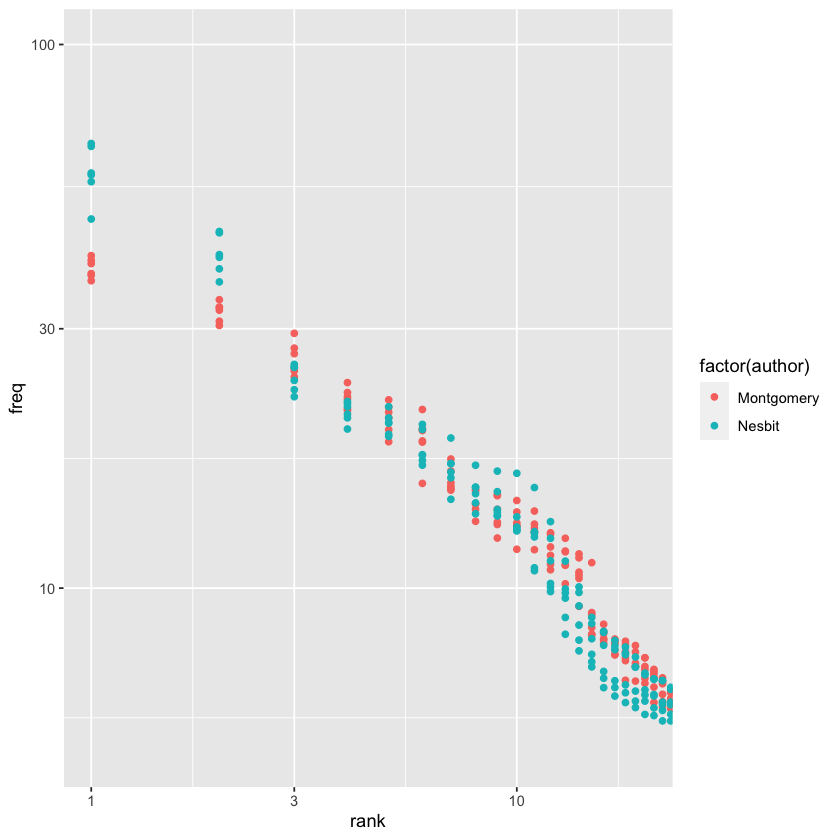

In [44]:
plot + 
    coord_cartesian(xlim=c(1,20), ylim=c(5,100))

Montgomery is consistently below Nesbit at the top of the Zipf curve, but really only for those two words... this might be fun to explore at another time.

## Identifying meaningful content words

Let’s turn our attention away from words that are common to the whole language towards those that are particular to certain documents. One common way to identify words that are important to a given document is the measure called **term frequency-inverse document frequency** or **TF-IDF**. This metric compares a word’s frequency in one document with its broader frequency in the corpus as a whole: words that occur in fewer documents throughout the corpus are weighted more heavily (that's "inverse document frequency").

For example, consider a Wikipedia page. Many of the most frequent words on the page will be words that are common throughout the site. Very rare words, on the other hand, may be only tangentially related to the page’s content. However, words that occur frequently on that page but are absent from most other pages are likely central to the subject of that page.

The tidytext package has a function, `bind_tf_idf()`, that calculates term frequencies and inverse document frequencies from a simple table of word counts.

Let's re-create our per-book word-counts, to demonstrate how `count()` and `bind_tf_idf()` can save us several steps from our earlier workflow:

In [45]:
freq_by_book <- corpus_words %>%
    count(gutenberg_id, word, sort=TRUE) %>%
    bind_tf_idf(term=word, document=gutenberg_id, n=n)

In [46]:
head(freq_by_book, n=20)

gutenberg_id,word,n,tf,idf,tf_idf
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
837,the,4581,0.06575567,0,0
3796,the,4245,0.04010506,0,0
836,the,4067,0.06495352,0,0
3536,the,4003,0.05801870,0,0
45,the,3925,0.03790293,0,0
3796,and,3591,0.03392633,0,0
47,the,3521,0.03953603,0,0
45,and,3398,0.03281380,0,0
1874,the,3366,0.05591827,0,0


In [47]:
tail(freq_by_book, n=20)

gutenberg_id,word,n,tf,idf,tf_idf
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
17314,wringing,1,1.825684e-05,1.3862944,2.530935e-05
17314,writer,1,1.825684e-05,0.5389965,9.840371e-06
17314,writing,1,1.825684e-05,0.0000000,0.000000e+00
17314,written,1,1.825684e-05,0.0000000,0.000000e+00
17314,yearling,1,1.825684e-05,2.4849066,4.536654e-05
17314,yelling,1,1.825684e-05,1.3862944,2.530935e-05
17314,yellowing,1,1.825684e-05,2.4849066,4.536654e-05
17314,yellowy,1,1.825684e-05,1.0986123,2.005719e-05
17314,yidey,1,1.825684e-05,2.4849066,4.536654e-05


Notice that the words with low frequencies (`tf`) have low TF-IDF scores as well; but words with very *high* frequencies have *even lower* TF-IDF scores, because function words are common to all the documents.

So what words have *high* TF-IDF scores?

In [48]:
freq_by_book %>% 
    arrange(desc(tf_idf)) %>% 
    head(n=20)

gutenberg_id,word,n,tf,idf,tf_idf
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1874,bobbie,471,0.007824570,2.4849066,0.019443326
836,phoenix,377,0.006021018,2.4849066,0.014961667
3536,mabel,414,0.006000435,2.4849066,0.014910520
3796,rilla,706,0.006670005,1.7917595,0.011951044
3536,gerald,590,0.008551344,1.3862944,0.011854680
1874,phyllis,282,0.004684774,2.4849066,0.011641227
770,oswald,233,0.004361009,2.4849066,0.010836701
3536,kathleen,289,0.004188709,2.4849066,0.010408552
837,anthea,383,0.005497581,1.3862944,0.007621266


<div style="float:right; width:140px; margin:1.5em">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Thwack%21_-_M.A._and_W.A.J._Claus.jpg/440px-Thwack%21_-_M.A._and_W.A.J._Claus.jpg">
</div>

The highest scores for these novels are proper names: characters who are prominent in a given novel’s storyline but don’t occur in the other books. (For those unfamiliar with Nesbit’s work, the "phoenix" here is the titular mythical beast from her novel, *The Phoenix and the Carpet*.

An interesting case for this somewhat artificial corpus is Anne (Shirley), the protagonist of L.M. Mongtomery’s *Anne of Green Gables* and its sequels. She's a common character to several of the Montgomery books in our corpus, which tends to reduce her name's TF-IDF score; but she's still absent from more than half the books, while being extremely common in the books where she does occur, so while not at the top of the list, she's still relatively prominent.